<a href="https://colab.research.google.com/github/a-zapala/MouseCells/blob/main/classification_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
ZIPPED_DATA_PATH = './MouEmbTrkDtb.zip'
UNZIPED_DATA_PATH = './MouEmbTrkDtb'
LABALED_DATA_PATH = './labeled/'

In [ ]:
!wget http://celltracking.bio.nyu.edu/MouEmbTrkDtb.zip

--2021-01-16 21:06:55--  http://celltracking.bio.nyu.edu/MouEmbTrkDtb.zip
Resolving celltracking.bio.nyu.edu (celltracking.bio.nyu.edu)... 128.122.4.26
Connecting to celltracking.bio.nyu.edu (celltracking.bio.nyu.edu)|128.122.4.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579849355 (3.3G) [application/zip]
Saving to: ‘MouEmbTrkDtb.zip’

MouEmbTrkDtb.zip    100%[===================>]   3.33G  44.0MB/s    in 67s     

2021-01-16 21:08:02 (50.9 MB/s) - ‘MouEmbTrkDtb.zip’ saved [3579849355/3579849355]



In [ ]:
!unzip -q {ZIPPED_DATA_PATH}

In [ ]:
import pandas as pd
import numpy as np
from shutil import copyfile
from pathlib import Path
from tqdm import tqdm

## Read classification of cells based on trajectoties.txt, which is provides by authors of dataset

In [ ]:
LABALED_DATA_PATH = './labeled/'
NUMBER_OF_CELL_EXAMPLES = 100
NUMBER_OF_CLASS = 4

for i in range(NUMBER_OF_CLASS):
    Path(os.path.join(LABALED_DATA_PATH, str(i))).mkdir(parents=True, exist_ok=True)

for sample in tqdm(range(NUMBER_OF_CELL_EXAMPLES)):
    sample_dir = os.path.join(UNZIPED_DATA_PATH, f"E{sample:02d}")
    
    df = pd.read_csv(os.path.join(sample_dir, "_trajectories.txt"), sep='\t', header=None)
    df = df[df.columns[2::3]]
    df.columns = range(7)
    df = df.astype(bool)
    df.index = df.index + 1

    df['class'] = np.nan
    df.loc[df[0], 'class'] = 0 
    df.loc[(df[1] & df[2]), 'class'] = 1
    df.loc[(df[3] & df[4] & df[2], 'class')] = 2
    df.loc[(df[1] & df[5] & df[6], 'class')] = 2
    df.loc[(df[3] & df[4] & df[5] & df[6], 'class')] = 3
    
    for index, row in df.iterrows():
        if ~np.isnan(row['class']):
            src_path = os.path.join(sample_dir, f"Frame{index:03d}.png")
            dst_path = os.path.join(LABALED_DATA_PATH, f"{int(row['class']):d}", f"{int(sample):02d}_{index:03d}.png")
            copyfile(src_path, dst_path)

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    LABALED_DATA_PATH, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    LABALED_DATA_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 24897 images belonging to 4 classes.
Found 6223 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


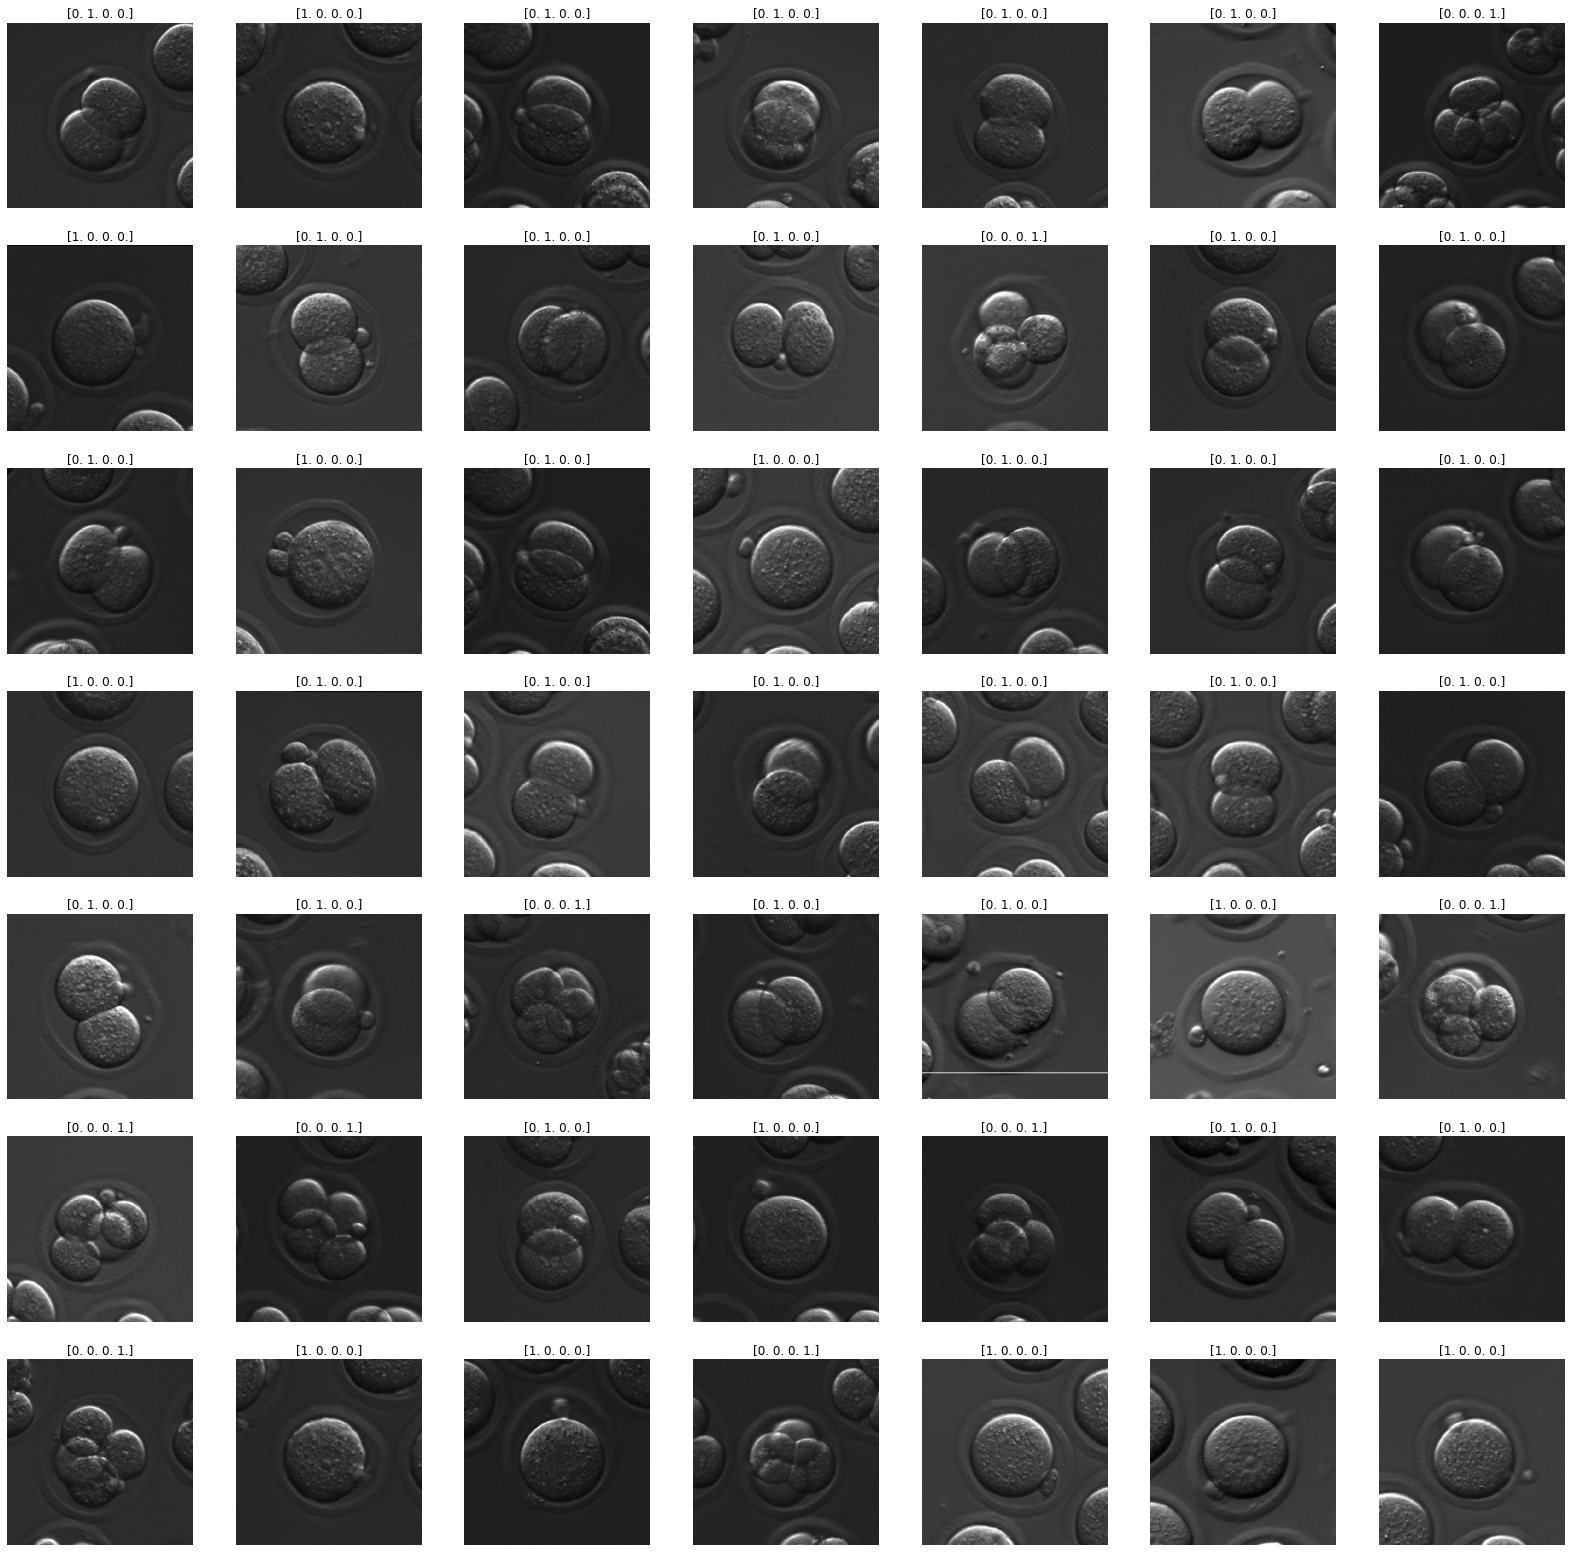

In [ ]:
import matplotlib.pyplot as plt
cols = 7
rows = 7

j = batch_size-1
fig = plt.figure(figsize=(4*cols, 4*rows))
for i in range(rows*cols):
    if j == batch_size-1:
        j = 0
        batch = next(train_generator)
    a = fig.add_subplot(rows, cols, i+1)
    a.axis('off')
    a.set_title(batch[1][j])
    a.imshow(batch[0][j][:,:,:])

    j += 1


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))

model = models.Sequential()
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(4, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 27,562,308
Trainable params: 27,562,308
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop( learning_rate=0.0001), metrics=['acc']) 
history = model.fit_generator( train_generator, epochs=10, validation_data=validation_generator, validation_steps=50 )

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


779/779 [==============================] - 331s 423ms/step - loss: 0.5931 - acc: 0.7738 - val_loss: 0.0568 - val_acc: 0.9850
Epoch 2/10
779/779 [==============================] - 335s 430ms/step - loss: 0.0609 - acc: 0.9862 - val_loss: 0.0694 - val_acc: 0.9831
Epoch 3/10
779/779 [==============================] - 333s 427ms/step - loss: 0.0540 - acc: 0.9888 - val_loss: 0.0651 - val_acc: 0.9850
Epoch 4/10
779/779 [==============================] - 331s 425ms/step - loss: 0.0337 - acc: 0.9933 - val_loss: 0.0178 - val_acc: 0.9937
Epoch 5/10
779/779 [==============================] - 331s 425ms/step - loss: 0.0441 - acc: 0.9930 - val_loss: 0.0548 - val_acc: 0.9912
Epoch 6/10
779/779 [==============================] - 331s 424ms/step - loss: 0.0531 - acc: 0.9931 - val_loss: 0.0265 - val_acc: 0.9906
Epoch 7/10
779/779 [==============================] - 329s 423ms/step - loss: 0.0620 - acc: 0.9949 - val_loss: 0.0246 - val_acc: 0.9950
Epoch 8/10
779/779 [==============================] - 329s 

In [ ]:
model.evaluate(validation_generator)

195/195 [==============================] - 29s 148ms/step - loss: 0.0321 - acc: 0.9937


[0.03211165592074394, 0.9937329292297363]

In [ ]:
from math import ceil

all_labels = np.array([])
all_predictions = np.array([])

batch_count = ceil(validation_generator.samples / batch_size)
for i in range(batch_count):
    imgs, labels = next(validation_generator)
    labels = np.argmax(labels, axis=1)
    predictions = np.argmax(model.predict(imgs), axis=1)
    all_predictions = np.concatenate([all_predictions, predictions])
    all_labels = np.concatenate([all_labels, labels])


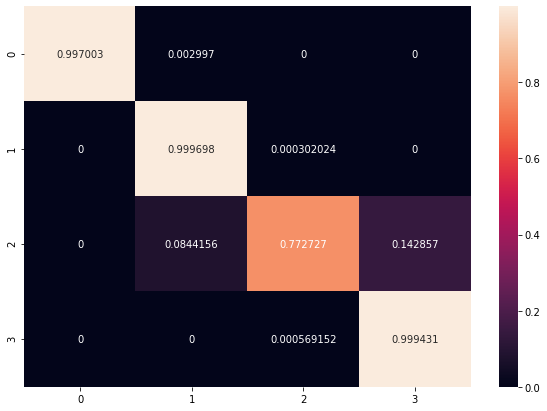

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

df_cm = pd.DataFrame(cm)

df_scaled = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (10,7))
sn.heatmap(df_scaled, annot=True, fmt='g')